In [24]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [25]:
import seaborn as sns
import pandas as pd
import sklearn
import sklearn.svm
import sklearn.metrics
from sklearn.cross_validation import train_test_split


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcess

from sklearn.neighbors import KernelDensity
from sklearn.grid_search import GridSearchCV

##Download the data

In [26]:
star_file = np.load("data/RR_Lyrae_data.npz")
star_colors, star_class = star_file['arr_0'], star_file['arr_1']

##Stack the data and store it in a pandas dataframe

In [27]:
stacked = np.hstack((star_colors, star_class.reshape(star_class.shape[0], 1)))
col_names = ['u-g', 'g-r', 'r-i', 'i-z', 'class']
star_df = pd.DataFrame(stacked, columns=col_names)

##Plot the enitre dataset with a pairplot from seaborn

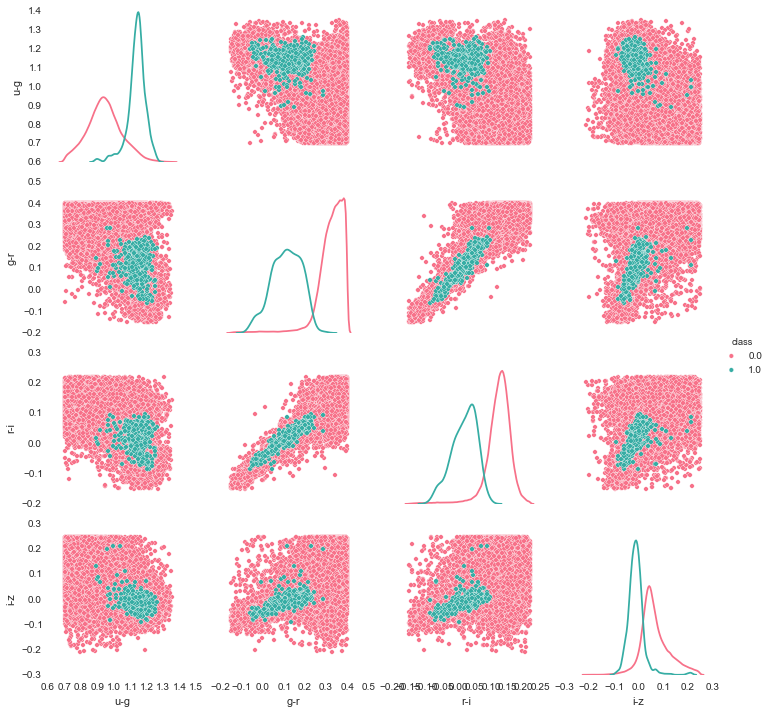

In [28]:
sns.pairplot(star_df, hue='class', vars=col_names[:-1], diag_kind="kde", palette='husl')

##Divide the data into train and test sets

In [29]:
colors_train, colors_test, labels_train, labels_test = train_test_split(star_colors, star_class, 
                                                                        test_size=0.25, random_state=13)

##Function to compute results

In [30]:
def compute_results(y_true, y_pred):
    fpr, tpr, thresholds_roc = sklearn.metrics.roc_curve(y_true, y_pred, pos_label=1)
    precision_p, recall_p, thresholds_pr = sklearn.metrics.precision_recall_curve(y_true, y_pred, pos_label=1)
    
    y_hard_decisions = np.round(y_pred)
    
    precision = sklearn.metrics.precision_score(y_true, y_hard_decisions)
    recall = sklearn.metrics.recall_score(y_true, y_hard_decisions)
    
    f1 = sklearn.metrics.f1_score(y_true, y_hard_decisions)
    roc_score = sklearn.metrics.roc_auc_score(y_true, y_hard_decisions)
    accuracy = sklearn.metrics.accuracy_score(y_true, y_hard_decisions)
    
    results = {'roc': [fpr, tpr, thresholds_roc],
               'pr': [precision_p, recall_p, thresholds_pr],
               'scores': [precision, recall, f1, roc_score, accuracy]}
    return results

##Functions to train models

In [31]:
def logistic_regression_classification(x_train, y_train, x_test, y_test):
    log_regr = LogisticRegression(class_weight='auto')
    log_regr.fit(x_train, y_train)
    predicted_proba = log_regr.predict_proba(x_test)[:, 1]
    return compute_results(y_test, predicted_proba)

In [32]:
def svm_classification(x_train, y_train, x_test, y_test):
    svm = SVC(kernel='linear', class_weight='auto', probability=True)
    svm.fit(x_train, y_train)
    predicted_proba = svm.predict_proba(x_test)[:, 1]
    return compute_results(y_test, predicted_proba)

In [33]:
def decision_Tree_classification(x_train, y_train, x_test, y_test):
    d_tree = DecisionTreeClassifier(max_depth=12, criterion='entropy')
    d_tree.fit(x_train, y_train)
    predicted_proba = d_tree.predict_proba(x_test)[:, 1]
    return compute_results(y_test, predicted_proba)

In [34]:
def knn_classification(x_train, y_train, x_test, y_test):
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(x_train, y_train)
    predicted_proba = knn.predict_proba(x_test)[:, 1]
    return compute_results(y_test, predicted_proba)

In [35]:
def random_forest_classification(x_train, y_train, x_test, y_test):
    rf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=2)
    rf.fit(x_train, y_train)
    predicted_proba = rf.predict_proba(x_test)[:, 1]
    return compute_results(y_test, predicted_proba)

In [36]:
def sigmoid(x):
    return 1./(1. + np.exp(-x))

def gaussian_process_classification(x_train, y_train, x_test, y_test):
    gp = GaussianProcess(theta0=20.)
    gp.fit(x_train[::20], y_train[::20])
    pred = gp.predict(x_test)
    probs = sigmoid(pred)
    return compute_results(labels_test, probs)

##Function to run the models and plot the results

In [37]:
def run_models(x_train, y_train, x_test, y_test):
    results = dict()
    
    #RUN Models
    
    #Logistic Regression
    logistic_results = logistic_regression_classification(x_train, y_train, x_test, y_test)
    results['Log Reg'] = logistic_results
    
    # SVM Basically the same as Logistic Regression and takes a while to train
#     svm_results = svm_classification(x_train, y_train, x_test, y_test)
#     results['SVM'] = svm_results
    
    #Decision Tree
    d_tree_resuts = decision_Tree_classification(x_train, y_train, x_test, y_test)
    results['D Tree'] = d_tree_resuts
    
    #KNN
    knn_resuts = knn_classification(x_train, y_train, x_test, y_test)
    results['KNN'] = knn_resuts
    
    #Random Forest
    rf_resuts = random_forest_classification(x_train, y_train, x_test, y_test)
    results['Random Forest'] = rf_resuts
    
#     #Gaussian Process
#     gp_resuts = gaussian_process_classification(x_train, y_train, x_test, y_test)
#     results['GP'] = gp_resuts
    
    # Print reports
    scores = []
    models = []
    for model, results_dict in results.items():
        models.append(model)
        scores.append(results_dict['scores'])
    
    column_names = ['precision', 'recall', 'F1', 'ROC_AUC', 'Accuracy']
    score_df = pd.DataFrame(scores, columns=column_names, index=models)
    print score_df
    
    #PLOT ROC
    for model, result_dict in results.items():
        plt.plot(result_dict['roc'][0], result_dict['roc'][1], label=model)
        
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    
    plt.figure()
    
    #PLOT Precision Recall
    for model, result_dict in results.items():
        plt.plot(result_dict['pr'][0], result_dict['pr'][1], label=model)
               
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.legend()
    

               precision    recall        F1   ROC_AUC  Accuracy
KNN             0.657407  0.572581  0.612069  0.785492  0.996135
D Tree          0.641026  0.604839  0.622407  0.801513  0.996092
Log Reg         0.139860  0.967742  0.244399  0.967940  0.968135
Random Forest   0.697674  0.241935  0.359281  0.620687  0.995405


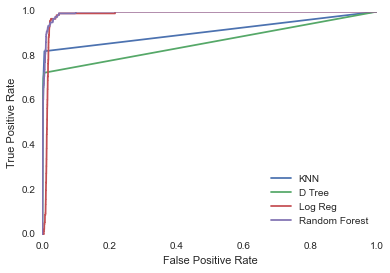

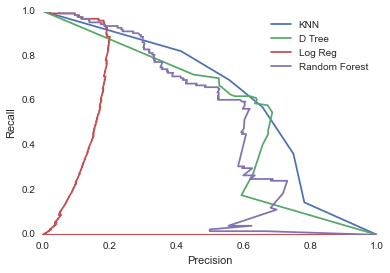

In [38]:
run_models(colors_train, labels_train, colors_test, labels_test)

##Adding new data of RR Stars with KDE

In [39]:
rr_stars = stacked[stacked[:, 4] == 1][:, :-1]

##Optimize KDE with a Gridsearch

In [40]:
params = {'bandwidth': np.logspace(-2, 2, 200)}
grid = GridSearchCV(KernelDensity(), params)
grid.fit(rr_stars)

print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))

# use the best estimator to compute the kernel density estimate
kde = grid.best_estimator_

best bandwidth: 0.0191164407539


##Sample New data

In [65]:
sampled_rr_stars = kde.sample(450, random_state=0)

In [66]:
def add_class_to_np_array(arr, cls):
    return np.array([np.concatenate([arr[i], [cls]])for i in xrange(arr.shape[0])])

##Plot the generated RR stars versus the actual stars to test the new KDE data

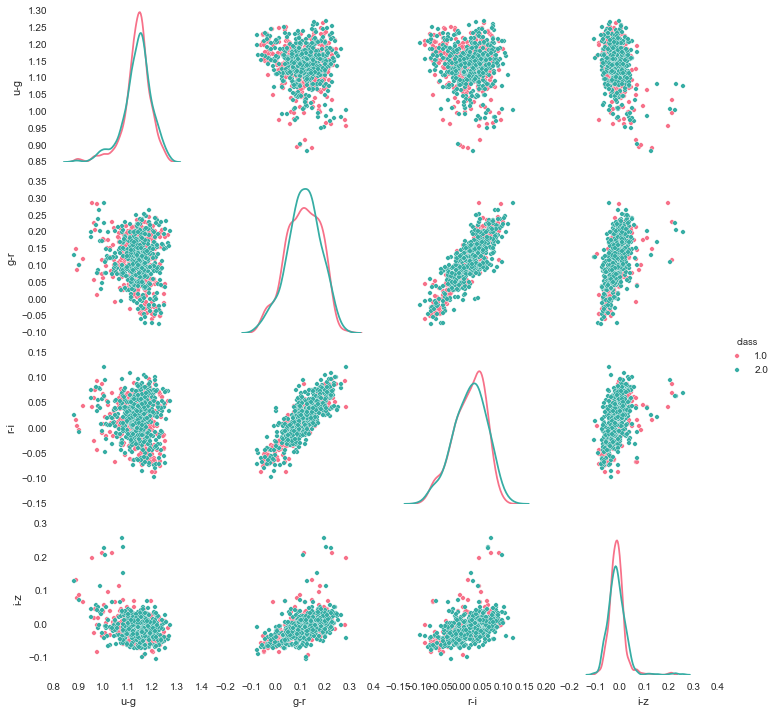

In [67]:
sampled_rr_class = add_class_to_np_array(sampled_rr_stars, 2)
rr_stack = np.vstack([add_class_to_np_array(rr_stars, 1), sampled_rr_class])
rr_df = pd.DataFrame(rr_stack, columns=col_names)
sns.pairplot(rr_df, hue='class', vars=col_names[:-1], diag_kind="kde", palette='husl')

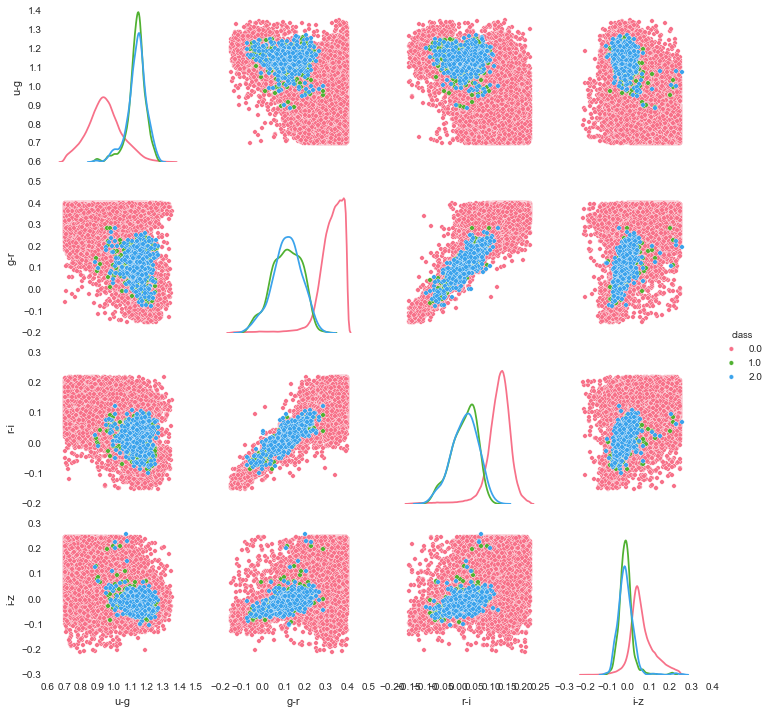

In [68]:
new_data_stack = np.vstack([stacked, sampled_rr_class])
new_data_df = pd.DataFrame(new_data_stack, columns=col_names)
sns.pairplot(new_data_df, hue='class', vars=col_names[:-1], diag_kind="kde", palette='husl')

## Test results with varying amout of kde data

In [44]:
amount_of_new_data = np.arange(1000, 26000, 5000)

In [45]:
def create_added_data_set(amount_new):
    new_rr_stars = kde.sample(amount_new, random_state=0)
    new_rr_with_class = add_class_to_np_array(new_rr_stars, 1)
    new_data = np.vstack([stacked, new_rr_with_class])
    return new_data[:, :-1], new_data[:, -1]


1000
               precision    recall        F1   ROC_AUC  Accuracy
KNN             0.706199  0.742210  0.723757  0.868754  0.991502
D Tree          0.677778  0.691218  0.684432  0.843107  0.990440
Log Reg         0.319381  0.994334  0.483471  0.981035  0.968134
Random Forest   0.714697  0.702550  0.708571  0.849140  0.991332
6000
               precision    recall        F1   ROC_AUC  Accuracy
KNN             0.866667  0.904416  0.885139  0.947237  0.984346
D Tree          0.836394  0.909256  0.871304  0.948273  0.982087
Log Reg         0.688054  0.986086  0.810542  0.977070  0.969257
Random Forest   0.852194  0.892922  0.872083  0.940928  0.982530
11000
               precision    recall        F1   ROC_AUC  Accuracy
KNN             0.903949  0.939152  0.921214  0.963380  0.982255
D Tree          0.893710  0.923853  0.908531  0.955104  0.979452
Log Reg         0.798533  0.984006  0.881620  0.976588  0.970810
Random Forest   0.884138  0.941933  0.912121  0.963303  0.979951
16000
   

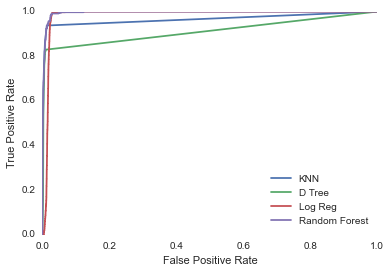

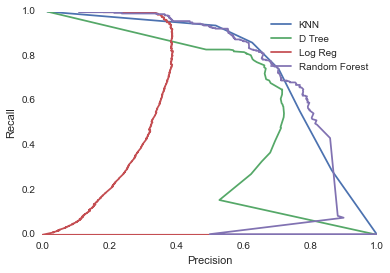

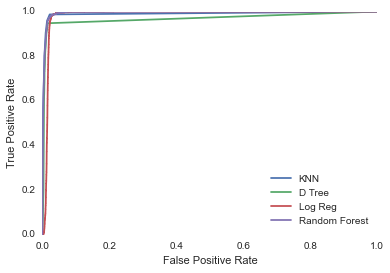

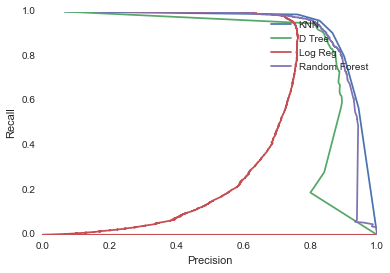

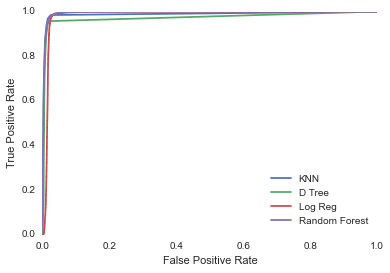

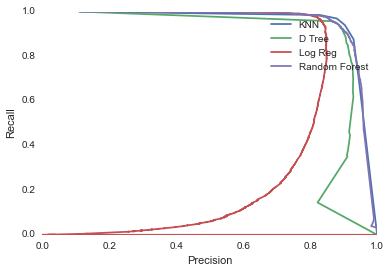

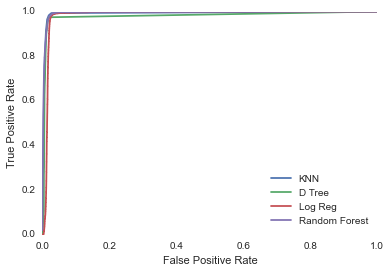

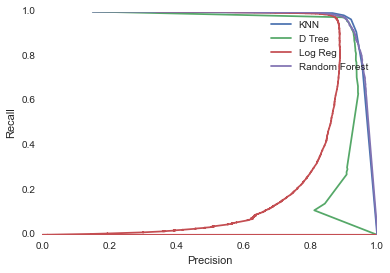

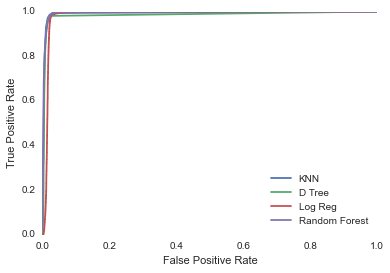

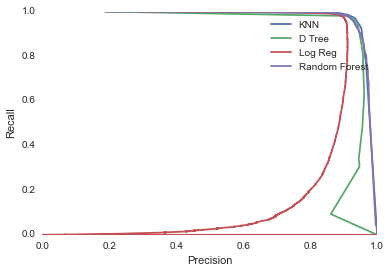

In [47]:
for rr_new in amount_of_new_data:
    new_colors, new_labels = create_added_data_set(rr_new)
    colors_train_n, colors_test_n, labels_train_n, labels_test_n = train_test_split(new_colors, new_labels, 
                                                                                    test_size=0.25, random_state=13)
    print rr_new
    run_models(colors_train_n, labels_train_n, colors_test_n, labels_test_n)
    plt.figure()
    
    

In [69]:
fig = plt.figure()

In [70]:
fig.scatter(np.arange(10), np.arange(10))

AttributeError: 'Figure' object has no attribute 'scatter'